## Keras NN Starter Kernel

In [1]:
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

## Data Loading
Just the standard loading of the data used in most other kernels. 

In [2]:
%%time
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')
train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

CPU times: user 3.69 s, sys: 504 ms, total: 4.19 s
Wall time: 4.51 s


In [3]:
# merge 
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))
print("Test shape  : "+str(test_df.shape))

Train shape : (80397, 433)
Test shape  : (10000, 432)


Dropping time since this likely isnt something we want our model to directly learn from

In [4]:
train_df = train_df.drop(["TransactionDT"], axis = 1)
test_df = test_df.drop(["TransactionDT"], axis = 1)

In [5]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [6]:
train_df['nulls1'] = train_df.isna().sum(axis=1)
test_df['nulls1'] = test_df.isna().sum(axis=1)

Selecting just the first set of columns and excluding the synthetic "v" features and other very sparse categoricals like deviceinfo and deviceid

In [7]:
train_df = train_df.iloc[:, :55]
test_df = test_df.iloc[:, :54]

In [8]:
del train_transaction, train_identity, test_transaction, test_identity

In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
#https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest_df-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [10]:
for c1, c2 in train_df.dtypes.reset_index().values:
    if c2=='O':
        train_df[c1] = train_df[c1].map(lambda x: str(x).lower())
        test_df[c1] = test_df[c1].map(lambda x: str(x).lower())

## Numerical and Categorical
Listing off and categorizing the various variables available to us. We have numerical and categoricals. We will treat both of these slightly differently later

In [12]:
numerical = ["TransactionAmt", "nulls1", "dist1", "dist2"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)] + \
            ["V" + str(i) for i in range(1, 340)]
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain_bin", "P_emaildomain_suffix", "R_emaildomain_bin", "R_emaildomain_suffix",
               "P_emaildomain", "R_emaildomain",
              "DeviceInfo", "DeviceType"] + ["id_0" + str(i) for i in range(1, 10)] +\
                ["id_" + str(i) for i in range(10, 39)] + \
                 ["M" + str(i) for i in range(1, 10)]


We already dropped a lot of these features because in some trial and error it was shown that these caused rapid overfitting for some reason or otherwise introduced unnecessary noise into the data. We will make sure we only list the features we actually have still in the df now

In [13]:
numerical = [col for col in numerical if col in train_df.columns]
categorical = [col for col in categorical if col in train_df.columns]

NN doesn't like nans so we will fill numerical columns with 0's. Previous people have tried plugging in the column means, but upon inspection this didn't seem very reliable because the train and test means for a given column could sometimes be drastically different. Plugging in zeros likely isnt the best. Might be better to plug in the train mean to the test df, but for simplicity I will stick with 0's for now. 

In [14]:
def nan2mean(df):
    for x in list(df.columns.values):
        if x in numerical:
            df[x] = df[x].fillna(0)
    return df
train_df=nan2mean(train_df)
test_df=nan2mean(test_df)

## Label Encoding
We will take our categorical features fill the nans and assign them an integer ID per category and write down the number of total categories per column. We'll use this later in an embedding layer of the NN

In [15]:
# Label Encoding
category_counts = {}
for f in categorical:
    train_df[f] = train_df[f].replace("nan", "other")
    train_df[f] = train_df[f].replace(np.nan, "other")
    test_df[f] = test_df[f].replace("nan", "other")
    test_df[f] = test_df[f].replace(np.nan, "other")
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[f].values) + list(test_df[f].values))
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))
    category_counts[f] = len(list(lbl.classes_)) + 1

In [41]:
from sklearn.preprocessing import StandardScaler

## Numerical Scaling

Now we will do some scaling of the data so that it will be in a more NN friendly format. First we will do log1p for any values that are above 100 and not below 0. This is in order to scale down any numerical variables that might have some extremely high values that screws up the statistics of the standard scaler 

After that we will pass them through the standard scaler so that the values have a normal mean and std. This makes the NN converge signficantly faster and prevents any blowouts. Feel free to try for yourself by commenting out this cell of code

In [42]:
for column in numerical:
    scaler = StandardScaler()
    if train_df[column].max() > 100 and train_df[column].min() >= 0:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    scaler.fit(np.concatenate([train_df[column].values.reshape(-1,1), test_df[column].values.reshape(-1,1)]))
    train_df[column] = scaler.transform(train_df[column].values.reshape(-1,1))
    test_df[column] = scaler.transform(test_df[column].values.reshape(-1,1))

In [43]:
target = 'isFraud'

In [44]:
#cut tr and val
tr_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42, shuffle = False)
from copy import deepcopy
val_df_pred = deepcopy(val_df)

Grabbing the features we want to pass into the neural network

In [45]:
def get_input_features(df):
    X = {'numerical':np.array(df[numerical])}
    for cat in categorical:
        X[cat] = np.array(df[cat])
    return X

## Neural Network Model Details

Our neural network will be fairly standard. We will use the embedding layer for categoricals and the numericals will go through feed forward dense layers. 

We create our embedding layers such that we have as many rows as we had categories and the dimension of the embedding is the log1p + 1 of the number of categories. So this means that categorical variables with very high cardinality will have more dimensions but not signficantly more so the information will still be compressed down to only about 13 dimensions and the smaller number of categories will be only 2-3.

We will then pass the embeddings through a spatial dropout layer which will drop dimensions within the embedding across batches and then flatten and concatenate. Then we will concatenate this to the numerical features and apply batch norm and then add some more dense layers after. 

In [46]:
import keras.backend as K

# loss function
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val  

In [47]:
from keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import  Adam
import keras.backend as k

#from livelossplot import PlotLossesKeras

def make_model():
    k.clear_session()

    categorical_inputs = []
    for cat in categorical:
        categorical_inputs.append(Input(shape=[1], name=cat))

    categorical_embeddings = []
    
    ## embedding layer:
    ## The first argument is the number of distinct values in the training set. 
    ## The second argument indicates the size of the embedding vectors.
    ## Once the network has been trained, we can get the weights of the embedding layer, 
    ## which can be thought as the table used to map integers to embedding vectors

    for i, cat in enumerate(categorical):
        categorical_embeddings.append(
            Embedding(category_counts[cat], int(np.log1p(category_counts[cat]) + 1), name = cat + "_embed")(categorical_inputs[i]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(.1)(cat_emb)) for cat_emb in categorical_embeddings])
#     categorical_logits = Dropout(.5)(categorical_logits)

    numerical_inputs = Input(shape=[tr_df[numerical].shape[1]], name = 'numerical')
    numerical_logits = Dropout(.1)(numerical_inputs)
  
    x = Concatenate()([
        categorical_logits, 
        numerical_logits,
    ])
#     x = categorical_logits
#     x = BatchNormalization()(x)
    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation = 'sigmoid')(x)
    

    model = Model(inputs=categorical_inputs + [numerical_inputs],outputs=out)
    loss = "binary_crossentropy"
    model.compile(optimizer=Adam(lr = 0.01), loss = loss, metrics=[f1])
    #model.summary()
    return model


We will then extract the features we actually want to pass to the NN

We will iterate through epochs of the model and save the model weights if the score is an improvement upon previous best roc_auc_scores since this is competition metric. If the NN does not improve upon previous best after 4 epochs we will skip the rest of the training steps to save time. 

In [48]:
from copy import deepcopy

In [49]:
categorical_save = deepcopy(categorical)
numerical_save = deepcopy(numerical)

## Greedy Feature Selection

First we will train the NN with all categorical and numerical features in order to make a baseline

After that we will greedily drop one feature at a time and see if it increases or decreases performance. If it increases upon dropping the feature then we will drop the feature. If it decreases then it will stay. 

In [50]:
# evaluation function
def compute_loss(df_pred, df_true, size):
    fraud_set = set(df_true[df_true['isFraud']==1]['TransactionID'])
    print(len(fraud_set))
    cutoff = df_pred['isFraud'].nlargest(size).iloc[-1]
    print('cutoff',cutoff)
    pass_set = set(df_pred[df_pred['isFraud']<cutoff]['TransactionID'])
    fraud_miss = fraud_set & pass_set
    df_fraud_miss = df_true[df_true['TransactionID'].isin(fraud_miss)]
    print('missed_fraud',df_fraud_miss.shape[0])
    loss = df_fraud_miss['TransactionAmt'].sum()
    print('mean missed fraud amt',loss/df_fraud_miss.shape[0])
    return loss  

In [51]:
# following code is using a stopping criteria based real loss
X_train = get_input_features(tr_df)
X_valid = get_input_features(val_df)
X_test = get_input_features(test_df)
y_train = tr_df[target]
y_valid = val_df[target]
model = make_model()
best_score = 0
patience = 0
for i in range(100):
    if patience < 3:
        hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), 
                         batch_size = 8000, epochs = 1, verbose = 1)
                        #,callbacks=[PlotLossesKeras()])
        valid_preds = model.predict(X_valid, batch_size = 8000, verbose = True)
        val_df_pred[target]=valid_preds
        score = compute_loss(val_df_pred, val_df, 1600)
        print(score)
        if score < best_score:
            model.save_weights("model.h5")
            best_score = score
            patience = 0
        else:
            patience += 1

Train on 64317 samples, validate on 16080 samples
Epoch 1/1
16080/16080 [==============================] - 2s 121us/step
448
cutoff 0.03107959
missed_fraud 222
mean missed fraud amt 0.13391184559760663
29.728429722668675
Train on 64317 samples, validate on 16080 samples
Epoch 1/1
16080/16080 [==============================] - 0s 9us/step
448
cutoff 0.06029868
missed_fraud 212
mean missed fraud amt 0.0220367923357662
4.671799975182434
Train on 64317 samples, validate on 16080 samples
Epoch 1/1
16080/16080 [==============================] - 0s 10us/step
448
cutoff 0.07958478
missed_fraud 186
mean missed fraud amt 0.07286023494791678
13.552003700312522


Dropping categoricals

In [52]:
drop_cats = []

In [53]:
for category_test in categorical_save:
    categorical = [cat for cat in categorical_save if cat not in drop_cats]
    categorical.remove(category_test)
    print(categorical)
    X_train = get_input_features(tr_df)
    X_valid = get_input_features(val_df)
    X_test = get_input_features(test_df)
    y_train = tr_df[target]
    y_valid = val_df[target]
    model = make_model()
    local_score = 0
    patience = 0
    for i in range(100):
        if patience < 3:
            hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 8000, epochs = 1, verbose = 0)
            valid_preds = model.predict(X_valid, batch_size = 8000, verbose = False)
            val_df_pred[target]=valid_preds
            score = compute_loss(val_df_pred, val_df, 1600)
            if score < local_score:
                model.save_weights("model.h5")
                local_score = score
                patience = 0
            else:
                patience += 1
        else:
            if local_score > best_score:
                print("performance reduced when", category_test, "increased to", local_score, "from", best_score)
                break
            else:
                drop_cats.append(category_test)
                print("performance increased when", category_test, "dropped to", local_score, "from", best_score)
                best_score = local_score
                model.save_weights("best_model.h5")
                break

['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
448
cutoff 0.010472029
missed_fraud 234
mean missed fraud amt 0.10669705482969181
448
cutoff 0.08935213
missed_fraud 196
mean missed fraud amt -0.02983534829178985
448
cutoff 0.05624649
missed_fraud 173
mean missed fraud amt 0.0950208855017428
448
cutoff 0.0770714
missed_fraud 169
mean missed fraud amt 0.10375989439711727
448
cutoff 0.05182028
missed_fraud 162
mean missed fraud amt 0.11511115087681065
performance increased when ProductCD dropped to -5.847728265190811 from 0
['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
448
cutoff 0.029973924
misse

In [54]:
drop_cats

['ProductCD', 'card2']

In [55]:
categorical = [cat for cat in categorical_save if cat not in drop_cats]

In [56]:
drop_nums = []

Dropping numeric

In [57]:
for numerical_test in numerical_save:
    numerical = [num for num in numerical_save if num not in drop_nums]
    numerical.remove(numerical_test)
    print(numerical)
    X_train = get_input_features(tr_df)
    X_valid = get_input_features(val_df)
    X_test = get_input_features(test_df)
    y_train = tr_df[target]
    y_valid = val_df[target]
    model = make_model()
    local_score = 0
    patience = 0
    for i in range(100):
        if patience < 4:
            hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 8000, epochs = 1, verbose = 0)
            valid_preds = model.predict(X_valid, batch_size = 8000, verbose = False)
            val_df_pred[target]=valid_preds
            score = compute_loss(val_df_pred, val_df, 1600)
            if score < local_score:
                model.save_weights("model.h5")
                local_score = score
                patience = 0
            else:
                patience += 1
        else:
            if local_score > best_score:
                print("performance reduced when", numerical_test, "increased to", local_score, "from", best_score)
                break
            else:
                drop_nums.append(numerical_test)
                print("performance increased when", numerical_test, "dropped to", local_score, "from", best_score)
                best_score = local_score
                model.save_weights("best_model.h5")
                break

67713857934 from -14.814529101423126
['TransactionAmt', 'dist1', 'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1']
448
cutoff 0.03082934
missed_fraud 249
mean missed fraud amt 0.13719974654591482
448
cutoff 0.06888023
missed_fraud 222
mean missed fraud amt 0.049946019540470114
448
cutoff 0.06991452
missed_fraud 176
mean missed fraud amt 0.10095567032030699
448
cutoff 0.05908826
missed_fraud 164
mean missed fraud amt 0.15765865211223512
performance reduced when C2 increased to 0 from -14.814529101423126
['TransactionAmt', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1']
448
cutoff 0.008551359
missed_fraud 217
mean missed fraud amt 0.0544264157598597
448
cutoff 0.08948749
missed_fraud 191
mean missed fraud amt 0.

In [58]:
print(drop_nums)

['dist2']


In [59]:
numerical = [num for num in numerical_save if num not in drop_nums]

In [60]:
model = make_model()

In [61]:
model.load_weights("best_model.h5")

## Tune for number of epoch

In [69]:
results = []
epoch_set = list(np.arange (5, 100, 5))
X_train = get_input_features(tr_df)
X_valid = get_input_features(val_df)
X_test = get_input_features(test_df)
y_train = tr_df[target]
y_valid = val_df[target]

for epo in epoch_set:
    hist = model.fit(X_train,y_train, batch_size = 8000, epochs = epo, verbose = 1)
    valid_preds = model.predict(X_valid, batch_size = 500, verbose = True)
    val_df_pred[target]=valid_preds
    score = compute_loss(val_df_pred, val_df, 1600)

    results.append([epo, score])

=====================] - 2s 27us/step - loss: 0.0146 - f1: 0.9049
Epoch 76/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0152 - f1: 0.8988
Epoch 77/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0137 - f1: 0.8992
Epoch 78/85
64317/64317 [==============================] - 2s 28us/step - loss: 0.0141 - f1: 0.9101
Epoch 79/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0149 - f1: 0.8900
Epoch 80/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0142 - f1: 0.8888
Epoch 81/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0156 - f1: 0.8855
Epoch 82/85
64317/64317 [==============================] - 2s 28us/step - loss: 0.0149 - f1: 0.8990
Epoch 83/85
64317/64317 [==============================] - 2s 27us/step - loss: 0.0144 - f1: 0.8886
Epoch 84/85
64317/64317 [==============================] - 2s 28us/step - loss: 0.0162 - f1: 0.8604
Epoch 85/85
16080/16080 [=========

In [70]:
results

[[5, -1.763199762545522],
 [10, -11.574285143596626],
 [15, -3.281456293370682],
 [20, -1.9958740594672941],
 [25, 2.383325896904263],
 [30, -0.2616230528540418],
 [35, 13.966921305410178],
 [40, 8.012609421548131],
 [45, 17.904557974437605],
 [50, 22.268533260390257],
 [55, 15.986610968620145],
 [60, 11.234284162346057],
 [65, 4.929310654227628],
 [70, 12.31522180892555],
 [75, 12.07767422148219],
 [80, 19.10843234505678],
 [85, 16.562849645957794],
 [90, 11.13300863808561],
 [95, 19.168374527131764]]

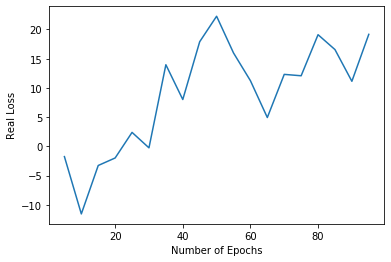

In [29]:
import matplotlib.pyplot as plt

results = np.array(results)
plt.plot(results[:,0],results[:,1]) 
plt.xlabel('Number of Epochs')
plt.ylabel('Real Loss')
plt.show()

In [79]:
results = []
epoch_set = list(np.arange (2, 24, 2))
X_train = get_input_features(tr_df)
X_valid = get_input_features(val_df)
X_test = get_input_features(test_df)
y_train = tr_df[target]
y_valid = val_df[target]
tr_df_pred = deepcopy(tr_df)

for epo in epoch_set:
    hist = model.fit(X_train,y_train, batch_size = 8000, epochs = epo, verbose = 1)
    valid_preds = model.predict(X_valid, batch_size = 500, verbose = True)
    train_preds = model.predict(X_train, batch_size = 500, verbose = True)

    val_df_pred[target]=valid_preds
    tr_df_pred[target]=train_preds
    score_1 = compute_loss(val_df_pred, val_df, 1608)
    score_2 = compute_loss(tr_df_pred, tr_df, 6432)

    results.append([epo, score_1, score_2])

Epoch 1/2
64317/64317 [==============================] - 1s 23us/step - loss: 0.0141 - f1: 0.9082
Epoch 2/2
64317/64317 [==============================] - 1s 15us/step
448
cutoff 0.0014043152
missed_fraud 128
mean missed fraud amt 0.12479365445465179
1668
cutoff 0.00041380525
missed_fraud 0
mean missed fraud amt nan
Epoch 1/4
64317/64317 [==============================] - 2s 24us/step - loss: 0.0130 - f1: 0.9006
Epoch 2/4
64317/64317 [==============================] - 2s 26us/step - loss: 0.0132 - f1: 0.9047
Epoch 3/4
64317/64317 [==============================] - 2s 26us/step - loss: 0.0125 - f1: 0.9159
Epoch 4/4
64317/64317 [==============================] - 1s 16us/step
448
cutoff 0.001105845
missed_fraud 134
mean missed fraud amt 0.0866135596199936
1668
cutoff 0.0002836585
missed_fraud 0
mean missed fraud amt nan
Epoch 1/6
64317/64317 [==============================] - 2s 26us/step - loss: 0.0138 - f1: 0.9119
Epoch 2/6
64317/64317 [==============================] - 2s 26us/step - l

In [80]:
results

[[2, 15.97358777019543, 0.0],
 [4, 11.606216989079144, 0.0],
 [6, 20.414396338368007, 0.0],
 [8, 17.960212559921125, 0.0],
 [10, 13.310692653841215, 0.0],
 [12, 15.853150753280936, 0.0],
 [14, 13.439059915637912, 0.0],
 [16, 11.764281356046167, 0.0],
 [18, 17.67512475564347, 0.0],
 [20, 22.346476445075172, 0.0],
 [22, 24.933777121689914, 0.0]]

As we can see above, the real loss fluctuate each time when we tune for the epoch. Overall, when epoch equal to 5, the real loss is smaller.

## Prediction on the Testset

In [81]:
X_test = get_input_features(test_df)

hist = model.fit(X_train,y_train, batch_size = 8000, epochs = 5, verbose = 1)
test_preds = model.predict(X_test, batch_size = 500, verbose = True)
sample_submission['isFraud'] = test_preds
sample_submission.to_csv('prediction_submission.csv')

Epoch 1/5
64317/64317 [==============================] - 2s 23us/step - loss: 0.0139 - f1: 0.9014
Epoch 2/5
64317/64317 [==============================] - 1s 23us/step - loss: 0.0130 - f1: 0.9207
Epoch 3/5
64317/64317 [==============================] - 1s 23us/step - loss: 0.0132 - f1: 0.9012
Epoch 4/5
64317/64317 [==============================] - 1s 23us/step - loss: 0.0139 - f1: 0.9029
Epoch 5/5
10000/10000 [==============================] - 0s 18us/step
